# Step 1. Inputs data

**Inputs Format**

Spanve model receive a `anndata.AnnData` object as input, and the `anndata.AnnData.obsm` key named `'spatail'` is required. Otherwise, specify the `spatial_info` parameter, which can be `str` of obsm key or `np.ndarray` and `pd.DataFrame` of spatial information.

**Preprocessing**

(Optional but recommended in most cases)

Note that: The preprocessing method is making the median of each gene keep the same with raw counts data. So, the preprocessing method is not suitable for data with negative values.

For most cases, we recommend to run the preprocessing method, but the preprocessing **may not be suitable** when: 

- data has only parts of genes.
- some cells have very low counts.
(thus, `scanpy.pp.filter_cells` and `scanpy.pp.filter_genes` are recommended to perform.)
- other cases that not considered now.

Spanve model is running in data with integer type. So, **RAW COUNTS** data can be directly used as input. But, if you want to use **NORMALIZED DATA**, you should preprocess the data first. The preprocessing method is as follows:

In [3]:
from Spanve import adata_preprocess_int
import scanpy as sc
import numpy as np
raw_adata = sc.read_h5ad('151507.h5ad')
sc.pp.filter_genes(raw_adata,min_cells=10)
sc.pp.filter_cells(raw_adata,min_genes=200)
# build-in preprocessing method
adata = adata_preprocess_int(raw_adata,exclude_highly_expressed=True)

In [ ]:
# customize the preprocessing method
def your_preprocess_method(adata):
    # do something
    return adata

adata = your_preprocess_method(raw_adata)
adata.X = ((adata.X / (1e-7+np.median(adata.X,axis=0))) * np.median(raw_adata.X,axis=0)).astype(int)


# Step 2. Fitting

Basic Model parameters

    adata: AnnData object
    spatial_info: spatial_infomation,default to adata.obsm['spatial'], defaults to None
    neighbor_finder: neighbor finder,could be 'knn' or 'Delaunay', defaults to None(>10000 use 'Delaunay',else use 'knn')
    hypoth_type: distribution hypoth,could be 'nodist' or 'possion', defaults to "nodist"
    verbose: verbose, defaults to False

CPU model parameters

    n_jobs: number of paralle workers, defaults to -1 (use all cpu cores)

GPU model parameters
    
    device: int = 1, device id, defaults to 1
    batch_size: int = 1024, batch size, defaults to 1024

gpu is supportted by cupy package, follow the instruction (https://docs.cupy.dev/en/stable/install.html) to install cupy.



In [5]:
from Spanve import Spanve,Spanve_gpu
# CPU parallel computing
spanve = Spanve(adata)
spanve.fit(verbose=True)

# GPU parallel computing
# spanve = Spanve_gpu(adata)
# spanve.fit(verbose=False)

# save and load the model
# Save file format as a csv file.
spanve.save('save_path') 
spanve.load('save_path')

#1 Expected Dist within Nodist Hypoth: 100%|██████████| 15818/15818 [00:02<00:00, 6985.51it/s]


#2 Nearest Neighbors Found


#3 Computing Absolute Substract Value: 100%|██████████| 15818/15818 [00:30<00:00, 517.56it/s]


#4 Entropy Calculated
#5 G-test Performed
Write results to adata.var['spanve_spatial_features']
#--- Done, using time 34.72 sec ---#


d:\Git\Spanve\Spanve\__init__.py:456: UserWarning: This function will not save input data. If you want to save input data, please use `anndata.AnnData.write_h5ad` function.
  warnings.warn('This function will not save input data. If you want to save input data, please use `anndata.AnnData.write_h5ad` function.')


In [14]:
# results:
spanve.fdrs,spanve.rejects,spanve.pvals
spanve.result_df

,ent,pvals,rejects,fdrs,max_expr
ENSG00000237491,0.0,1.0,False,1.0,0
ENSG00000225880,0.0,1.0,False,1.0,0
ENSG00000223764,0.0,1.0,False,1.0,0
ENSG00000187634,0.0,1.0,False,1.0,0
ENSG00000188976,0.0,1.0,False,1.0,0
...,...,...,...,...,...
ENSG00000274847,0.0,1.0,False,1.0,0
ENSG00000276256,0.0,1.0,False,1.0,0
ENSG00000273748,0.0,1.0,False,1.0,0
ENSG00000278817,0.0,1.0,False,1.0,0


In [18]:
print(spanve.adata)
print(spanve.adata.var)
print(spanve.adata.uns['spanve_running_parmas'])

AnnData object with n_obs × n_vars = 4218 × 15818
    obs: 'n_genes', 'ground_truth'
    var: 'n_cells', 'spanve_spatial_features'
    uns: 'log1p', 'spanve_running_parmas'
    obsm: 'spatial'
                 n_cells  spanve_spatial_features
ENSG00000237491       57                    False
ENSG00000225880       12                    False
ENSG00000223764       10                    False
ENSG00000187634       18                    False
ENSG00000188976      435                    False
...                  ...                      ...
ENSG00000274847       19                    False
ENSG00000276256       10                    False
ENSG00000273748       60                    False
ENSG00000278817      530                    False
ENSG00000277196       44                    False

[15818 rows x 2 columns]
{'K': 42, 'hypoth_type': 'nodist', 'neighbor_finder': 'knn', 'n_jobs': -1, 'verbose': False}


# Extension: Imputation, clustering and visulization

Imputation if recommended to perform in a `float` preprocessed data on selected genes.

And there is also a Kmeans clustering class for auto selecting clustering number in Spanve which is based on elbow method.

In [10]:
# -- spatial imputation
from Spanve import adata_preprocess
X = adata_preprocess(raw_adata).X
X_ = spanve.impute_from_graph(X[:,spanve.rejects])

# -- clustering with spatial imputation data
from sklearn.decomposition import PCA
from Spanve import AutoCluster
pca = PCA(n_components=50)
X_ = pca.fit_transform(X_)
cluster = AutoCluster(init_k=3,max_k=10,criteria='inertia') # criteria: 'inertia','bic','ch','si','db'
labels = cluster.fit_predict(X_,verbose=True)

Sample size: 4218, using model: KMeans


finding best cluster number: 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

Best k: 6, Now predicting


<AxesSubplot:title={'center':'Elbow for inertia'}, xlabel='k', ylabel='inertia'>

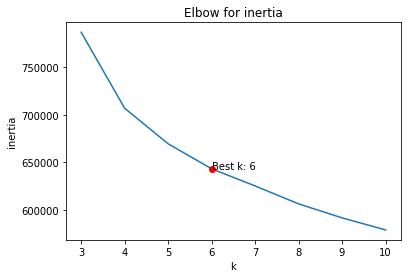

In [ ]:
cluster.plot_elbow()

<AxesSubplot:>

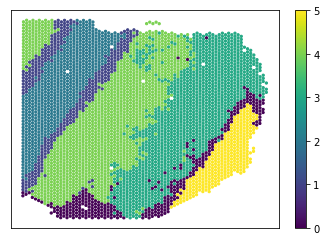

In [11]:
spanve.plot_spatial(labels)

<AxesSubplot:>

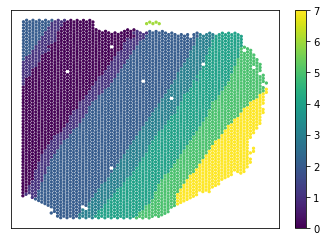

In [13]:
spanve.plot_spatial(adata.obs['ground_truth'].astype(object))